In [1]:
import keras
import numpy as np
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.layers.embeddings import Embedding
import matplotlib
#matplotlib.use('Agg')
#import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

#import nltk
#from nltk.corpus import stopwords
#from nltk.stem import SnowballStemmer
import re
import string
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.contrib import rnn
from sklearn.cross_validation import train_test_split
from tensorflow.contrib import learn
import os
from collections import defaultdict
from keras.callbacks import EarlyStopping
#from gensim import corpora
#pd.set_option('display.max_rows', 1000000000)

C:\Users\Mahdi\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Mahdi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
labels_csv = pd.read_csv("data\\data_singl_tweet_per_line.csv")
labels_csv.head()

,user_id,label,tweet_id
0,user_1,aggressor,657684957272387584
1,user_1,aggressor,657695791134416896
2,user_1,aggressor,656838718666493952
3,user_1,aggressor,657193317709565952
4,user_1,aggressor,657688224601632768


In [3]:
tweets_csv = pd.read_csv("data\\data_tweets.csv", header=0, delimiter=",bbbbbbbbbbb", quoting=3)

for i in range(len(tweets_csv)):
    s = tweets_csv.iloc[i,1]
    s = s[1:-1]
    tweets_csv.iloc[i,1] = s

tweets_csv.head()

C:\Users\Mahdi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,tweet_id,tweet
0,692398237689327616,#ProChoice #Abortion Faith and the 2016 Campai...
1,660430372501499904,#HuffPost #Tcot 3 Things to Never Say to an Al...
2,692432098309705728,#Salon #Tcot Venezuela doctors fume at officia...
3,663300853479018496,@tweetbeinghuman Men work tirelessly without t...
4,660180643637260288,#Homophobia Gay priest: The Church makes the l...


In [4]:
merged = tweets_csv.merge(labels_csv, on='tweet_id')
merged = merged.drop_duplicates()
merged = merged.reset_index(drop=True)

# remove spams
merged = merged[merged.label != 'spammer']
merged = merged.reset_index(drop=False)
merged.head()

,index,tweet_id,tweet,user_id,label
0,0,692398237689327616,#ProChoice #Abortion Faith and the 2016 Campai...,user_11,aggressor
1,1,660430372501499904,#HuffPost #Tcot 3 Things to Never Say to an Al...,user_8,aggressor
2,2,692432098309705728,#Salon #Tcot Venezuela doctors fume at officia...,user_11,aggressor
3,3,663300853479018496,@tweetbeinghuman Men work tirelessly without t...,user_2,aggressor
4,4,660180643637260288,#Homophobia Gay priest: The Church makes the l...,user_8,aggressor


In [5]:
tweets_list = merged['tweet'].tolist()
labels_list = merged['label'].tolist()

max_wordNum = 0
for tweet in tweets_list:
    tweet_splitted = tweet.split()
    if len(tweet_splitted) > max_wordNum:
        max_wordNum = len(tweet_splitted)

In [6]:
vocab_processor = learn.preprocessing.VocabularyProcessor(max_wordNum)
vocab_processor.fit_transform(tweets_list)
vocab_dict = vocab_processor.vocabulary_._mapping

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [7]:
def pre_trained_embedding(dictionary,filename):

    embeddings_index = {}
    f = open(filename, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    #print('Found %s word vectors.' % len(embeddings_index))

    embedding_matrix = np.zeros((len(dictionary), 200))
    for word, i in dictionary.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [8]:
M_pre_train=pre_trained_embedding(vocab_dict,'glove.twitter.27B\\glove.twitter.27B.200d.txt')

In [9]:
X = np.array(list(vocab_processor.transform(tweets_list)))

s = pd.Series(labels_list)
Y = np.array(pd.get_dummies(s))

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.25)
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,test_size=0.333)

In [10]:
embedding_vecor_length = 200
class_count = Y.shape[1]

model = Sequential()
model.add(Embedding(len(vocab_dict),embedding_vecor_length,weights=[M_pre_train],input_shape=(max_wordNum,),trainable=True, name='Embedding'))
model.add(LSTM(100,return_sequences=False,name='LSTM'))
model.add(Dense(20,activation='relu',name='Hidden_Layer_1'))
model.add(Dense(class_count, activation='softmax', name='Softmax_Layer'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 30, 200)           3074600   
_________________________________________________________________
LSTM (LSTM)                  (None, 100)               120400    
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 20)                2020      
_________________________________________________________________
Softmax_Layer (Dense)        (None, 3)                 63        
Total params: 3,197,083
Trainable params: 3,197,083
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
callbacks=[EarlyStopping(monitor='val_loss',patience=5,verbose=1)]

history = model.fit(X_train,y_train,
                    validation_data=[X_valid,y_valid],
                    epochs=50, 
                    batch_size=100
                    ,callbacks=callbacks
                   )

Train on 1734 samples, validate on 867 samples
Epoch 1/50
1734/1734 [==============================] - 4s 2ms/step - loss: 0.6874 - acc: 0.9164 - val_loss: 0.1117 - val_acc: 0.9804
Epoch 2/50
1734/1734 [==============================] - 3s 2ms/step - loss: 0.1548 - acc: 0.9712 - val_loss: 0.1083 - val_acc: 0.9804
Epoch 3/50
1734/1734 [==============================] - 3s 2ms/step - loss: 0.1465 - acc: 0.9712 - val_loss: 0.1084 - val_acc: 0.9804
Epoch 4/50
1734/1734 [==============================] - 3s 2ms/step - loss: 0.1457 - acc: 0.9712 - val_loss: 0.1065 - val_acc: 0.9804
Epoch 5/50
1734/1734 [==============================] - 3s 2ms/step - loss: 0.1450 - acc: 0.9712 - val_loss: 0.1076 - val_acc: 0.9804
Epoch 6/50
1734/1734 [==============================] - 3s 2ms/step - loss: 0.1449 - acc: 0.9712 - val_loss: 0.1059 - val_acc: 0.9804
Epoch 7/50
1734/1734 [==============================] - 3s 2ms/step - loss: 0.1455 - acc: 0.9712 - val_loss: 0.1110 - val_acc: 0.9804
Epoch 8/50
1734

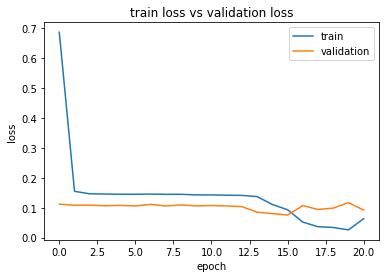

In [12]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

In [13]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12574404951030482
Test accuracy: 0.9815668202764977
